# **Spotify Song Popularity Analysis/Song Recommender**
# **Introduction:**
*   This dataset from kaggle.com gives me a spreadsheet with hundreds of thousands of songs.
*   Each song gives song attributes such as artist, title, genre, tempo, danceability, acousticness, valence, etc.
*   The goal of this project is to 1.) Find trends within the dataset using SQL, and 2.) Create a simple song recommending system using cosin similarity scores.




# **Import Libraries and Data Set**

In [1]:
from google.colab import drive # link my google drive to this colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
# Connect to an in-memory SQLite database
conn = sql.connect(':memory:')

# Read the CSV file into a Pandas DataFrame
df = pd.read_excel('/content/drive/MyDrive/spotify_excel.xlsx') # put the spreadsheet into a data frame

# Write the DataFrame to an SQLite table
df.to_sql('spotify_db', conn, index=False)

df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# **SQL Data Analysis**

In [ ]:
# df = df.drop('explicit', axis = 1)
df = df.drop(df.columns[0], axis = 1) # drop the first column which came with an extra column with indexes
print(df['popularity'].quantile(0.90))
print(df['popularity'].quantile(0.75)) # Calculate the 75th percentile of the popularity metric
print(+ df['popularity'].mean()) # Calculate the 50th percentile of the popularity metric.
df.head() # show what the df looks like

63.0
50.0
33.2385350877193


,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


*   **With SQLite, we can easily sift through data with SQL queries.**
*   **Here, I am calling a simple SQL query that will output all of the artists that have songs with a popularity rating over the third quartile**






In [ ]:
query1 = """SELECT artists, popularity
            FROM spotify_db WHERE popularity >= 33.23853"""
result1 = pd.read_sql(query1, conn)
print(result1)



                      artists  popularity
0                 Gen Hoshino          73
1                Ben Woodward          55
2      Ingrid Michaelson;ZAYN          57
3                Kina Grannis          71
4            Chord Overstreet          82
...                       ...         ...
58413           Planetshakers          40
58414           Planetshakers          38
58415           Jesus Culture          38
58416            Chris Tomlin          39
58417        Michael W. Smith          41

[58418 rows x 2 columns]




*   **Here, I am grouping by artists.**
*   **This will output which artists had the most songs with above average popularity. This excludes classical music**
*   **Unsurprisingly, the Beatles took the first spot by a mile. However, Linkin park took the second spot which I found to be pretty suprising. BTS and Elvis being at 3 and 4 was as expected, but Linkin Park being at the number 2 spot may lead to questions of biased data gathering**






In [ ]:
query2 = """SELECT artists, COUNT(*) as name_count
            FROM spotify_db
            WHERE popularity >= 50 AND (LOWER(track_genre) != 'classical') AND (LOWER(track_genre) NOT LIKE 'x%' OR LOWER(track_genre) NOT LIKE '%x')
            GROUP BY artists
            ORDER BY name_count DESC LIMIT 26;"""
result2 = pd.read_sql(query2, conn)
print(result2)

                  artists  name_count
0             The Beatles         275
1             Linkin Park         153
2                     BTS         151
3           Elvis Presley         145
4          Arctic Monkeys         121
5   Red Hot Chili Peppers          91
6               Rammstein          91
7           Prateek Kuhad          87
8                 Nirvana          83
9    Cigarettes After Sex          71
10                  Adele          69
11           XXXTENTACION          67
12             Pink Floyd          67
13            OneRepublic          67
14            Lamb of God          62
15             John Mayer          62
16               Jay Chou          62
17   Bring Me The Horizon          60
18      The Neighbourhood          56
19     Henrique & Juliano          56
20              CoComelon          54
21            The Strokes          52
22                 Gojira          52
23                Tove Lo          51
24           Arijit Singh          51
25          



*   **Here, I am again sorting by artists.**
*   **However, this time, I am sorting by songs with a popularity rating >= 63, which is the 90th percentile.**
*   **Some interesting things happens when I sort this way. BTS takes the top spot, and Elvis drops down 15 spots for example.**
*   **This implies that BTS has less songs that have average populairty, but more songs that have very high popularity ratings.**




In [ ]:
query4 = """SELECT artists, COUNT(*) as name_count
            FROM spotify_db
            WHERE popularity >= 63.0 AND (LOWER(track_genre) != 'classical') AND (LOWER(track_genre) NOT LIKE 'x%' OR LOWER(track_genre) NOT LIKE '%x')
            GROUP BY artists
            ORDER BY name_count DESC LIMIT 26;"""
result4 = pd.read_sql(query4, conn)
print(result4)

                  artists  name_count
0                     BTS         128
1             The Beatles         105
2             Linkin Park          78
3   Red Hot Chili Peppers          73
4          Arctic Monkeys          63
5       The Neighbourhood          56
6    Cigarettes After Sex          56
7                   Adele          54
8               Rammstein          52
9               Bad Bunny          48
10           XXXTENTACION          44
11                 Halsey          44
12                Nirvana          43
13               The 1975          41
14             John Mayer          40
15            OneRepublic          39
16              Metallica          39
17              BLACKPINK          38
18          Elvis Presley          37
19          Guns N' Roses          34
20   Bring Me The Horizon          33
21    My Chemical Romance          32
22             Billy Joel          32
23             Nickelback          31
24           Daddy Yankee          29
25       Thr



*   **Here, I am ordering songs by popularity. Only a few songs have a popularity rating > 90. Here are what the songs are as well as the artists.**


In [ ]:
query3 = """SELECT DISTINCT track_name, popularity, artists
            FROM spotify_db
            ORDER BY popularity DESC LIMIT 25;"""
result3 = pd.read_sql(query3, conn)
print(result3)

                                 track_name  popularity  \
0                 Unholy (feat. Kim Petras)         100   
1     Quevedo: Bzrp Music Sessions, Vol. 52          99   
2                           I'm Good (Blue)          98   
3                                La Bachata          98   
4                           Me Porto Bonito          97   
5                        TitÃ­ Me PreguntÃ³          97   
6                       Under The Influence          96   
7                                    Efecto          96   
8                           I Ain't Worried          96   
9                             Ojitos Lindos          95   
10                                As It Was          95   
11                                   Efecto          95   
12                              Moscow Mule          94   
13                            Glimpse of Us          94   
14                            Ojitos Lindos          94   
15                          Sweater Weather          93 



*   **I could spend hundreds of lines looking at individual relationships between all of the variables in this data base and their correlations with popularity, but this would be best visualized in a heat map.**
*   **As you can see in the top row of the heat map, Song qualties such as Valence (0.14), Loudness (0.14), and Danceability (0.12) all have higher correlations with the popularity of a song, but there is not one qualtiy that trumps all of the others**
*   **Qualties such as instrumentalness (-0.19), and acousticness (-0.12) all correlate with lower popularity ratings which explains why loud rock bands such as The Beatles, Linkin Park, and The Red Hot Chili Peppers are ranked so high in the above outputs, and slower acoustic based artists such as John Mayer are ranked lower.**






<ipython-input-69-b7e5bba7f065>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = corr_df.corr()


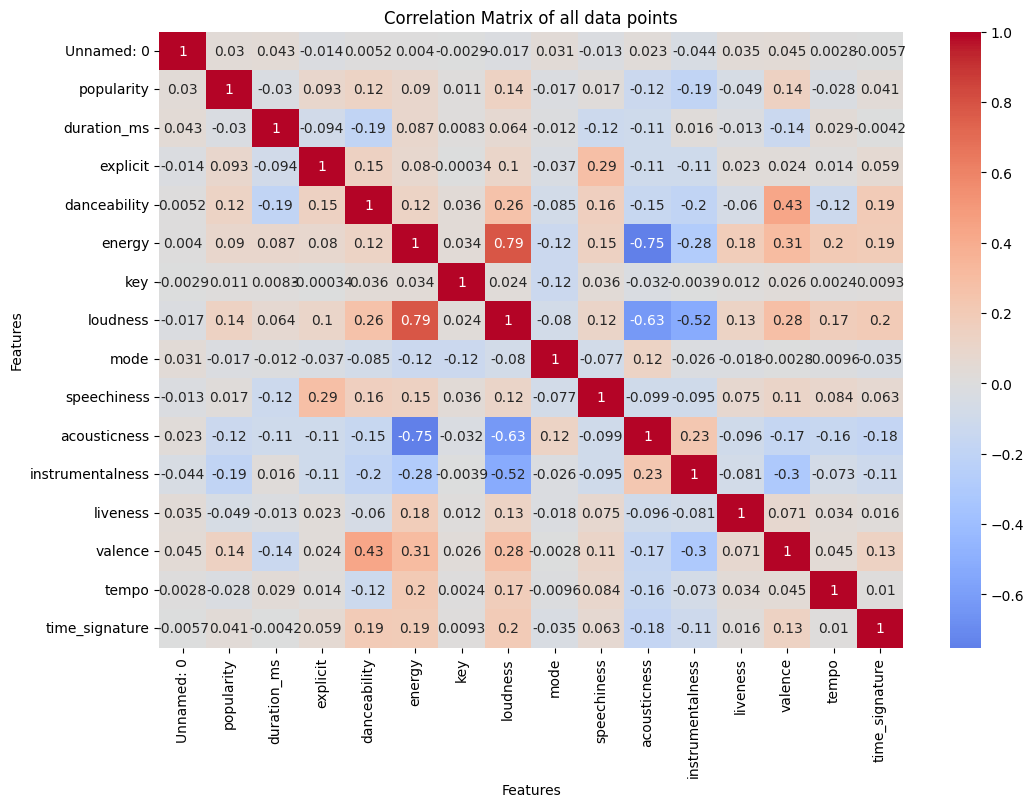

In [69]:
corr_df = df[df['popularity']>50]
corr_matrix = corr_df.corr()
mp.figure(figsize=(12,8)) # size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center =0)
mp.title("Correlation Matrix of all data points")
mp.xlabel("Features")
mp.ylabel("Features")
mp.show()

# **Song Recommendation System**



**Genre Encoding**





In [38]:
df = df[df['popularity'] >= 50] # This makes the dataset more manageable. Google Colab does not offer enough RAM for free to run such a large dataset through certain functions in my code
xtab_song = pd.crosstab(
    df['track_id'],
    df['track_genre']
) # The goal of this line is to summarize how many times each track ID appears in each genre.

xtab_song = xtab_song*2 # doubles all the counts

display(xtab_song.head(8),len(xtab_song)) # display
# the second song is Mr. Brightside

track_genre,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,brazil,...,soul,spanish,study,swedish,synth-pop,techno,trance,trip-hop,turkish,world-music
track_id,,,,,,,,,,,,,,,,,,,,,
000RDCYioLteXcutOjeweY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003vvx7Niy0yvhvHt4a68B,0,0,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004h8smbIoAkUNDJvVKwkG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0068lzo1xXa9ED8ThypHU1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0072MKNpMeJNx8aRfTNfQW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00B7SBwrjbycLMOgAmeIU8,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00Coyxt9mTec1acC52qtWa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00CsDW3I9XueUvaXnAvGMm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


21210

In [39]:
# Concatenate the encoded genre columns with the original dataframe

newdf = df.drop_duplicates('track_id') # Gets rid of duplicates
newdf = newdf.sort_values('track_id') # Sorts in ascending order
newdf = newdf.reset_index(drop=True) # resets index.

xtab_song.reset_index(inplace=True) # resets index.
data_encoded = pd.concat([newdf, xtab_song], axis=1) # concatenates newdf and xtab_song.
display(data_encoded.head(),len(data_encoded))

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,soul,spanish,study,swedish,synth-pop,techno,trance,trip-hop,turkish,world-music
0,51365,000RDCYioLteXcutOjeweY,Jordan Sandhu,Teeje Week,Teeje Week,62,190203,False,0.679,0.770,...,0,0,0,0,0,0,0,0,0,0
1,2106,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,...,0,0,0,0,0,0,0,0,0,0
2,33178,004h8smbIoAkUNDJvVKwkG,Ouse;Powfu,Loners Diary,Lovemark,58,219482,True,0.808,0.331,...,0,0,0,0,0,0,0,0,0,0
3,36468,0068lzo1xXa9ED8ThypHU1,Horizon Blue;Carston,Got You On My Mind,Got You On My Mind,58,154426,False,0.814,0.532,...,0,0,0,0,0,0,0,0,0,0
4,55183,0072MKNpMeJNx8aRfTNfQW,Pritam;Arijit Singh,Holiday - A Soldier Is Never Off Duty (Origina...,Shaayraana,58,261439,False,0.604,0.665,...,0,0,0,0,0,0,0,0,0,0


21210

In [72]:
numerical_features = ['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence'] # creates numerical_features list which has all song attributes.
scaler = MinMaxScaler() # scales everything from 0-1
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features]) #changes the value of all of the attirbutes in the numerical_features list
display(data_encoded.head())

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,soul,spanish,study,swedish,synth-pop,techno,trance,trip-hop,turkish,world-music
0,51365,000RDCYioLteXcutOjeweY,Jordan Sandhu,Teeje Week,Teeje Week,62,190203,0.0,0.692857,0.770766,...,0,0,0,0,0,0,0,0,0,0
1,2106,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,0.0,0.359184,0.911910,...,0,0,0,0,0,0,0,0,0,0
2,33178,004h8smbIoAkUNDJvVKwkG,Ouse;Powfu,Loners Diary,Lovemark,58,219482,1.0,0.824490,0.331318,...,0,0,0,0,0,0,0,0,0,0
3,36468,0068lzo1xXa9ED8ThypHU1,Horizon Blue;Carston,Got You On My Mind,Got You On My Mind,58,154426,0.0,0.830612,0.532523,...,0,0,0,0,0,0,0,0,0,0
4,55183,0072MKNpMeJNx8aRfTNfQW,Pritam;Arijit Singh,Holiday - A Soldier Is Never Off Duty (Origina...,Shaayraana,58,261439,0.0,0.616327,0.665659,...,0,0,0,0,0,0,0,0,0,0


**Similarity Calculation**

In [41]:
calculated_features = numerical_features + list(xtab_song.drop(columns='track_id').columns) # creates a list of the numerical features from the previous cells and the crosstabulated table frome earlier.
cosine_sim = cosine_similarity(data_encoded[calculated_features], data_encoded[calculated_features]) # creates similarity scores
display(cosine_sim)

array([[1.        , 0.20465125, 0.21298479, ..., 0.33012552, 0.26089147,
        0.28955253],
       [0.20465125, 1.        , 0.10877135, ..., 0.1555372 , 0.14190909,
        0.17607931],
       [0.21298479, 0.10877135, 1.        , ..., 0.2023389 , 0.16199123,
        0.17293551],
       ...,
       [0.33012552, 0.1555372 , 0.2023389 , ..., 1.        , 0.3006789 ,
        0.26099846],
       [0.26089147, 0.14190909, 0.16199123, ..., 0.3006789 , 1.        ,
        0.23219057],
       [0.28955253, 0.17607931, 0.17293551, ..., 0.26099846, 0.23219057,
        1.        ]])

In [54]:
def get_recommendations(title, N=5): # define function
    indices = pd.Series(data_encoded.index, index=data_encoded['track_name']).drop_duplicates() #

    try: # if song name is not found.
        idx = indices[title]
        try:
            len(idx)
            temp = 2
        except:
            temp = 1
    except KeyError:
        return "Song not found in the dataset."

    if temp == 2:
        idx = indices[title][0]
    else:
        idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    song_indices = [i[0] for i in sim_scores]
    recommended_songs = data_encoded[['track_name', 'artists', 'album_name']].iloc[song_indices]

    sim_scores_list = [i[1] for i in sim_scores]
    recommended_list = recommended_songs.to_dict(orient='records')
    for i, song in enumerate(recommended_list):
        song['similarity_score'] = sim_scores_list[i]

    return recommended_list

**SONG RECOMMENDER. Replace "Let's Groove" with any song and view the recommended songs below!**

In [65]:
# Get the recommendations
recommended_songs = get_recommendations("Let's Groove", N=5) # SONG INPUT!For this example, I am using Lets's Groove by Earth, Wind, and Fire which is a popular dance song!
if isinstance(recommended_songs, str):
    print(recommended_songs)
else:
    print("Recommended Songs:")
    for song in recommended_songs:
        print(f"Title: {song['track_name']}")
        print(f"Artist: {song['artists']}")
        print(f"Album: {song['album_name']}")
        print(f"Similarity Score: {song['similarity_score']:.2f}")
        print()

Recommended Songs:
Title: Super Freak
Artist: Rick James
Album: Street Songs (Deluxe Edition)
Similarity Score: 1.00

Title: Please Don't Go
Artist: KC & The Sunshine Band
Album: Do You Wanna Go Party
Similarity Score: 0.99

Title: September
Artist: Earth, Wind & Fire
Album: The Best Of Earth, Wind & Fire Vol. 1
Similarity Score: 0.89

Title: Lovely Day
Artist: Bill Withers
Album: Menagerie
Similarity Score: 0.85

Title: Ain't No Mountain High Enough
Artist: Marvin Gaye;Tammi Terrell
Album: United
Similarity Score: 0.85




# **Conclusion**
*   This model recommends songs to users, however it is relatively elementary model.
*   There is a lot of room for improvement. Including genre, language, and weighting certiain attributes more than others would be a great start. I hope to implement these changes in the near future!
*   This model works especiall well for upbeat, danceable songs!


